Для удобства работы ноутбук лучше запускать в Google Colab (там предустановлены нужные библиотеки)

Загрузите файл для обработки и укажите его название:

In [5]:
filename = 'karot3.png'

# Import & requirements

При установке библиотек потребуется перезапустить сеанс, а затем еще раз все ячейки

In [ ]:
!pip install paddlepaddle paddleocr
!pip install pdf2image
!sudo apt-get install poppler-utils

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from google.colab.patches import cv2_imshow
from paddleocr import PaddleOCR, draw_ocr
from pdf2image import convert_from_path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Preprocessing

In [8]:
if filename.split('.')[-1].lower() == 'pdf':
  img = convert_from_path(filename)[0]
else:
  img = Image.open(filename)

Делаем понасыщеннее и конвертируем в чб, чтобы оценить яркость каждого пикселя

In [9]:
img = Image.open(filename)
converter = ImageEnhance.Color(img)
img_raw = converter.enhance(4)
img_bw = img_raw.convert('L')

In [10]:
def color_similarity(a, b, delta):
  if abs(a[0] - b[0]) < delta and abs(a[1] - b[1]) < delta and abs(a[2] - b[2]) < delta:
    return True
  else:
    return False

Фильтруем из всего изображения только пиковые пиксели (самые выделяющиеся пиксели точно не являются фоном)

In [11]:
x_dist = 7
color_dist = 20

arr_bw = np.array(img_bw)
arr_raw = np.array(img_raw)

points = []

for y_idx in range(arr_bw.shape[0]):
  row = arr_bw[y_idx, :]
  points.append([])
  for x_idx in range(1, row.shape[0] - 1):
    if row[x_idx] <= row[x_idx - 1] and row[x_idx] <= row[x_idx + 1] and row[x_idx] < np.quantile(row, .1, axis = 0):
      color = arr_raw[y_idx, x_idx].tolist()
      points[-1].append([x_idx, color])

Видим самые яркие точки на изображении

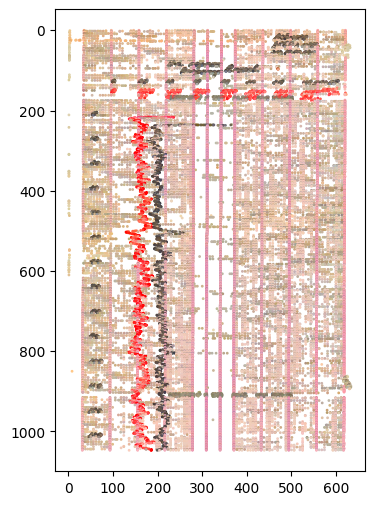

In [12]:
x = []
y = []
c = []
colors = []
for i in range(len(points)):
    x += [j[0] for j in points[i]]
    y += [i]*len(points[i])
    c += [[j[1][0]/255, j[1][1]/255, j[1][2]/255] for j in points[i]]
    colors += [[j[1][0], j[1][1], j[1][2]] for j in points[i]]

plt.figure(figsize=(4, 6))
plt.gca().invert_yaxis()
plt.scatter(x, y, c=c, s=1)

# Processing

Кластеризуем самые яркие точки по цветам, в процессе находя оптимальное число кластеров

In [14]:
data = np.array(colors)

def find_best_k(data, k_range):
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
        print(f'For n_clusters = {k}, silhouette score = {score}')

    best_k = k_range[np.argmax(silhouette_scores)]
    return best_k, silhouette_scores

k_range = range(2, 11)

best_k, silhouette_scores = find_best_k(data, k_range)

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(data)

print(best_k)

For n_clusters = 2, silhouette score = 0.6560497481494861
For n_clusters = 3, silhouette score = 0.679395016976409
For n_clusters = 4, silhouette score = 0.47576889789731336
For n_clusters = 5, silhouette score = 0.4735170616023065
For n_clusters = 6, silhouette score = 0.47720047637230123
For n_clusters = 7, silhouette score = 0.473307334347925
For n_clusters = 8, silhouette score = 0.4469590106334978
For n_clusters = 9, silhouette score = 0.4485869666752544
For n_clusters = 10, silhouette score = 0.44246716747836284
3


Превью разделения диаграммы на слои

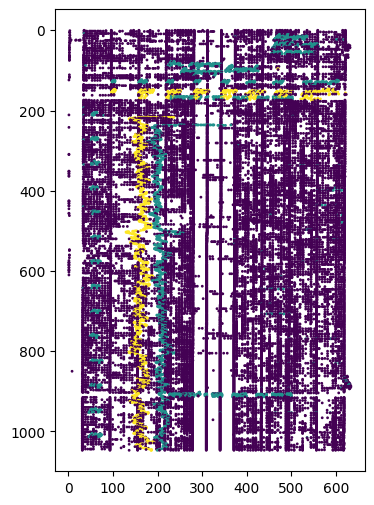

In [15]:
plt.figure(figsize=(4, 6))
plt.gca().invert_yaxis()
plt.scatter(x, y, c=labels, s=1)

Рассмотрим распознавание на примере одной диаграммы

TODO: сделать экспорт всех колонок с диаграммами, они отличаются от фона разбросом точек по плоскости


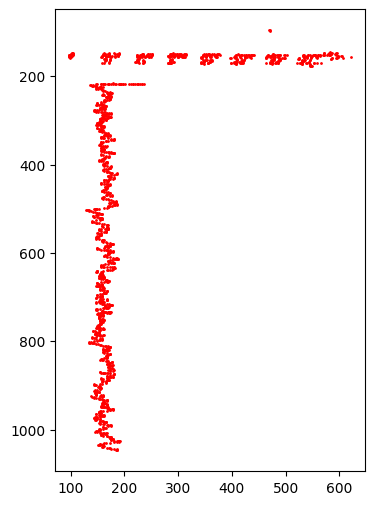

In [16]:
label = 2

x_f = []
y_f = []
c_f = []

for i in range(len(x)):
  if labels[i] == label:
    x_f.append(x[i])
    y_f.append(y[i])
    c_f.append(c[i])

plt.figure(figsize=(4, 6))
plt.gca().invert_yaxis()
plt.scatter(x_f, y_f, c='r', s=1)

Убираем сильно горизонтальные участки (это надписи того же цвета, что и диаграмма), оставляем по одной точке на каждое значение высоты

In [17]:
max_n_horiz = 3

dots = np.hstack((np.array(x_f).reshape(-1, 1), np.array(y_f).reshape(-1, 1)))
column = []

for i in range(max(y_f)):
  row = dots[(dots[:,1] == i)]
  if len(row) <= max_n_horiz:
    if len(row) != 0:
      column.append(row[len(row) // 2][0])
    else:
      column.append(np.nan)

Убираем оставшиеся выбросы и заполняем пропуски интерполяцией

TODO: экспорт в .csv

In [18]:
column = np.array(column)

mean = np.nanmean(column)
sd = np.nanstd(column)

column = column[(column[:] > mean - 2 * sd)]
column = column[(column[:] < mean + 2 * sd)]

ok = ~np.isnan(column)
xp = ok.ravel().nonzero()[0]
fp = column[~np.isnan(column)]
x  = np.isnan(column).ravel().nonzero()[0]

column[np.isnan(column)] = np.interp(x, xp, fp)

Превью полученного графика

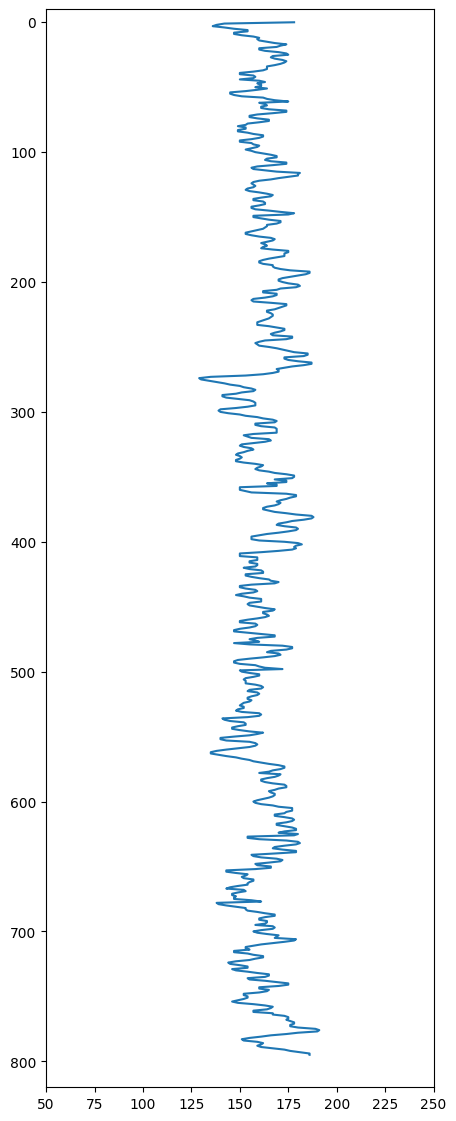

In [19]:
f, ax = plt.subplots()
f.set_figheight(14)
f.set_figwidth(5)

ax.plot(column)
plt.gca().invert_yaxis()
ax.set_ylim([0, 500])

newx = ax.lines[0].get_ydata()
newy = ax.lines[0].get_xdata()

ax.set_ylim([-10, 820])
ax.set_xlim([50, 250])
plt.gca().invert_yaxis()
ax.lines[0].set_xdata(newx)
ax.lines[0].set_ydata(newy)

Можно сравнить с левой диаграммой на изображении, график достаточно точный

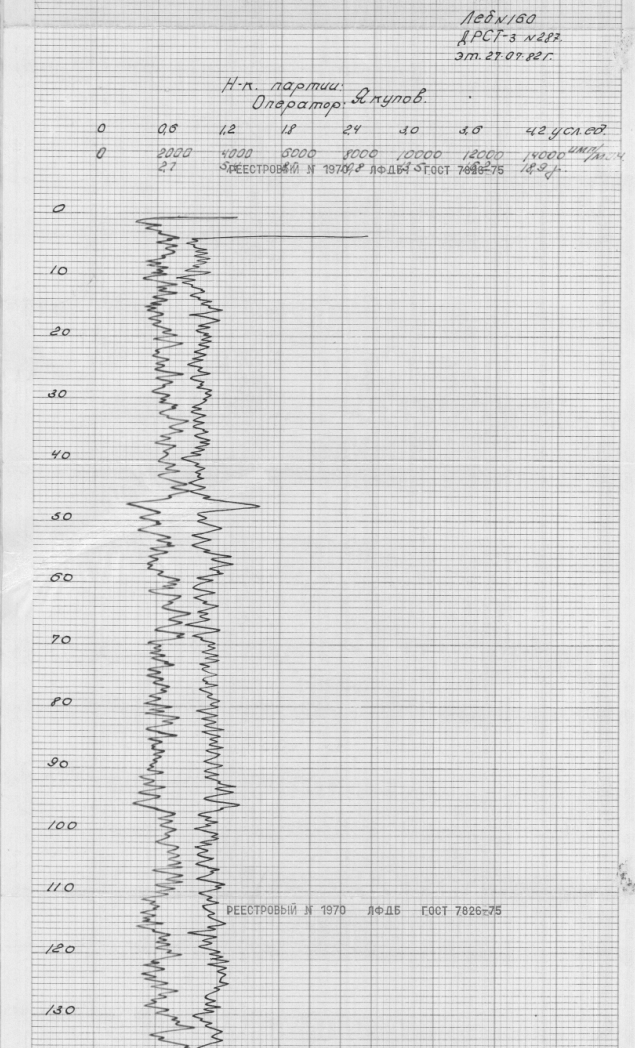

In [22]:
cv2_imshow(arr_bw)

# OCR

Были испробованы разные варианты OCR для считывания масштаба, лучше всех себя показал PaddleOCR. Не успели применить его здесь для применения масштаба к графику, однако потенциально это сделать не сложно

TODO: получаем распознанные повторяющиеся цифры и применяем их как деления шкалы масштаба

In [23]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

if filename.split('.')[-1].lower() == 'pdf':
  print('Обработка PDF еще не готова')

else:
  result = ocr.ocr(filename, cls=True)
  for idx in range(len(result)):
      res = result[idx]
      for line in res:
          print(line)

  result = result[0]
  image = Image.open(filename).convert('RGB')
  boxes = [line[0] for line in result]
  txts = [line[1][0] for line in result]
  scores = [line[1][1] for line in result]
  im_show = draw_ocr(image, boxes, txts, scores, font_path='simfang.ttf')
  im_show = Image.fromarray(im_show)
  im_show.save('ocr.jpg')

download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 4.00M/4.00M [00:08<00:00, 465kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10.2M/10.2M [00:18<00:00, 567kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:06<00:00, 335kiB/s]

[2024/05/25 18:50:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='

[2024/05/25 18:50:19] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.4480726718902588
[2024/05/25 18:50:20] ppocr DEBUG: cls num  : 37, elapsed : 0.14140009880065918
[2024/05/25 18:50:21] ppocr DEBUG: rec_res num  : 37, elapsed : 1.7510223388671875
[[[461.0, 8.0], [539.0, 8.0], [539.0, 26.0], [461.0, 26.0]], ('Me6N160', 0.6493231058120728)]
[[[454.0, 48.0], [556.0, 48.0], [556.0, 63.0], [454.0, 63.0]], ('3m.270982', 0.8616988658905029)]
[[[222.0, 75.0], [344.0, 79.0], [344.0, 97.0], [221.0, 94.0]], ('H-k. napmuu', 0.7645768523216248)]
[[[246.0, 93.0], [345.0, 95.0], [345.0, 114.0], [246.0, 111.0]], ('Onepamop', 0.9650073051452637)]
[[[348.0, 84.0], [429.0, 86.0], [428.0, 109.0], [347.0, 107.0]], ('Anynob', 0.81248539686203)]
[[[97.0, 123.0], [107.0, 123.0], [107.0, 135.0], [97.0, 135.0]], ('0', 0.5837318897247314)]
[[[158.0, 121.0], [184.0, 121.0], [184.0, 142.0], [158.0, 142.0]], ('06', 0.7634540796279907)]
[[[216.0, 124.0], [238.0, 116.0], [244.0, 134.0], [222.0, 141.0]], ('1.2', 0.8357

Цифры шкалы распознаются хорошо

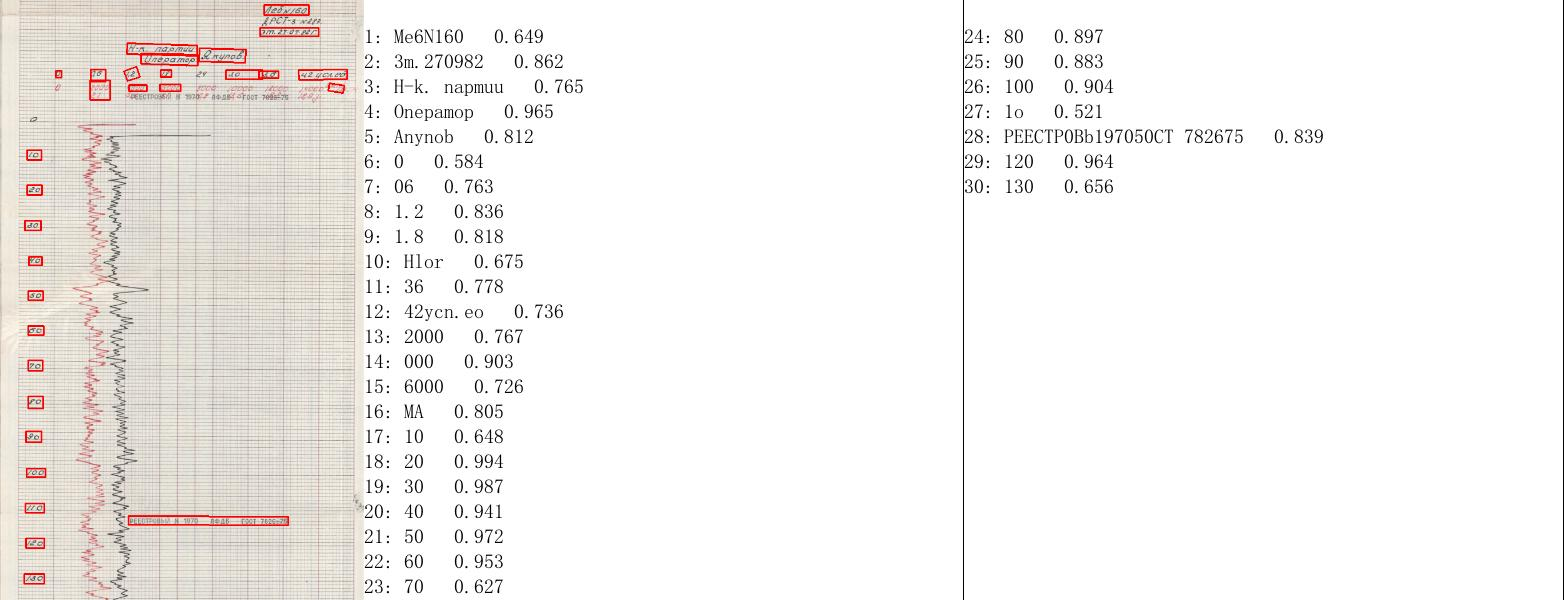

In [24]:
Image.open("ocr.jpg")